# NewsApp ML Training - Manual Training Notebook

This notebook trains a **Collaborative Filtering recommendation model** for NewsApp.

## 📋 What This Notebook Does:
1. **Fetches data** from Firebase Firestore (user interactions, preferences, bookmarks)
2. **Processes data** for collaborative filtering (matrix factorization)
3. **Trains model** using Alternating Least Squares (ALS) or SVD
4. **Exports model** to JSON format (`ML_ModelArtifacts`)
5. **Saves dataset** backup as JSON in `datasets/` folder
6. **Generates model** JSON in `models/` folder ready for Firebase Storage upload

## 💰 100% FREE - No Cloud Functions Required!

## ⚙️ Requirements:
- Python 3.8+
- Firebase Admin SDK
- Service Account Key JSON (download from Firebase Console)
- Internet connection to fetch data

## 🚀 How to Use:
1. Run all cells in order
2. Follow prompts for Firebase credentials
3. Review training statistics
4. Upload generated model JSON to Firebase Storage manually

---

## Step 1: Install Required Libraries

Run this cell first to install all dependencies.

In [56]:
# Install required packages using conda (Anaconda)
# Run this in Anaconda Prompt or terminal with conda activated:
# conda install numpy pandas scikit-learn matplotlib seaborn tqdm -y
# pip install firebase-admin

# Or run directly from notebook (uncomment below):
# !conda install numpy pandas scikit-learn matplotlib seaborn tqdm -y
# !pip install firebase-admin

print("✅ If using Anaconda, run these commands in Anaconda Prompt:")
print("   conda install numpy pandas scikit-learn matplotlib seaborn tqdm -y")
print("   pip install firebase-admin")
print("\n✅ Or uncomment the lines above to install from notebook")

✅ If using Anaconda, run these commands in Anaconda Prompt:
   conda install numpy pandas scikit-learn matplotlib seaborn tqdm -y
   pip install firebase-admin

✅ Or uncomment the lines above to install from notebook


## Step 2: Import Libraries and Setup Paths

In [57]:
import firebase_admin
from firebase_admin import credentials, firestore, storage
import json
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup paths
BASE_DIR = Path.cwd()
DATASET_DIR = BASE_DIR / "datasets"
MODEL_DIR = BASE_DIR / "models"

# Create directories if not exist
DATASET_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

print(f"✅ Base directory: {BASE_DIR}")
print(f"✅ Dataset directory: {DATASET_DIR}")
print(f"✅ Model directory: {MODEL_DIR}")
print(f"✅ Libraries imported successfully!")

✅ Base directory: d:\UMN\MAP\NewsApp\ml_training
✅ Dataset directory: d:\UMN\MAP\NewsApp\ml_training\datasets
✅ Model directory: d:\UMN\MAP\NewsApp\ml_training\models
✅ Libraries imported successfully!


## Step 3: Initialize Firebase Connection

**🔑 IMPORTANT: Download Service Account Key**

1. Go to [Firebase Console](https://console.firebase.google.com/)
2. Select your project: **newsapp-fae0d**
3. Click ⚙️ **Settings** → **Project settings**
4. Go to **Service accounts** tab
5. Click **Generate new private key**
6. Save the JSON file as: `serviceAccountKey.json` in this folder (`ml_training/`)

⚠️ **Keep this file SECRET** - Add to `.gitignore`!

In [58]:
# Initialize Firebase Admin SDK
try:
    # Path to service account key
    SERVICE_ACCOUNT_PATH = BASE_DIR / "serviceAccountKey.json"
    
    if not SERVICE_ACCOUNT_PATH.exists():
        raise FileNotFoundError(
            f"❌ Service account key not found!\n"
            f"Expected location: {SERVICE_ACCOUNT_PATH}\n\n"
            f"Please download it from Firebase Console:\n"
            f"1. Go to Project Settings → Service Accounts\n"
            f"2. Click 'Generate new private key'\n"
            f"3. Save as 'serviceAccountKey.json' in ml_training/ folder"
        )
    
    # Check if Firebase is already initialized
    try:
        # Try to get existing app
        app = firebase_admin.get_app()
        print("✅ Firebase already initialized, reusing existing connection")
    except ValueError:
        # App doesn't exist, initialize it
        cred = credentials.Certificate(str(SERVICE_ACCOUNT_PATH))
        firebase_admin.initialize_app(cred, {
            'storageBucket': 'newsapp-fae0d.appspot.com'
        })
        print("✅ Firebase initialized successfully!")
    
    # Get Firestore client
    db = firestore.client()
    print(f"✅ Connected to project: newsapp-fae0d")
    
except Exception as e:
    print(f"❌ Error initializing Firebase: {e}")
    raise

✅ Firebase already initialized, reusing existing connection
✅ Connected to project: newsapp-fae0d


## Step 4: Fetch Data from Firestore

Fetching user interaction data from Firebase collections.

In [59]:
def fetch_user_interactions():
    """Fetch all user interactions from Firestore"""
    print("📡 Fetching user interactions...")
    
    interactions = []
    users_ref = db.collection('user_interactions')
    users = users_ref.list_documents()
    
    for user_doc in tqdm(users, desc="Users"):
        user_id = user_doc.id
        articles_ref = user_doc.collection('articles')
        
        for article_doc in articles_ref.stream():
            data = article_doc.to_dict()
            interactions.append({
                'user_id': user_id,
                'article_id': article_doc.id,
                'clicks': data.get('clicks', 0),
                'last_clicked': data.get('lastClicked'),
                'reading_time': data.get('readingTime', 0)
            })
    
    print(f"✅ Fetched {len(interactions)} interactions")
    return interactions

def fetch_user_preferences():
    """Fetch user ML preferences (category scores)"""
    print("📡 Fetching user preferences...")
    
    preferences = []
    users_ref = db.collection('user_preferences')
    users = users_ref.list_documents()
    
    for user_doc in tqdm(users, desc="Preferences"):
        user_id = user_doc.id
        ml_data_ref = user_doc.collection('ml_data').document('preferences')
        ml_data = ml_data_ref.get()
        
        if ml_data.exists:
            data = ml_data.to_dict()
            preferences.append({
                'user_id': user_id,
                'category_scores': data.get('categoryScores', {}),
                'total_interactions': data.get('totalInteractions', 0),
                'last_updated': data.get('lastUpdated')
            })
    
    print(f"✅ Fetched {len(preferences)} user preferences")
    return preferences

def fetch_bookmarks():
    """Fetch user bookmarks"""
    print("📡 Fetching bookmarks...")
    
    bookmarks = []
    users_ref = db.collection('user_bookmarks')
    users = users_ref.list_documents()
    
    for user_doc in tqdm(users, desc="Bookmarks"):
        user_id = user_doc.id
        bookmarks_ref = user_doc.collection('bookmarks')
        
        for bookmark_doc in bookmarks_ref.stream():
            data = bookmark_doc.to_dict()
            bookmarks.append({
                'user_id': user_id,
                'article_id': bookmark_doc.id,
                'added_at': data.get('addedAt'),
                'category': data.get('category', 'Unknown')
            })
    
    print(f"✅ Fetched {len(bookmarks)} bookmarks")
    return bookmarks

# Fetch all data
interactions_data = fetch_user_interactions()
preferences_data = fetch_user_preferences()
bookmarks_data = fetch_bookmarks()

print("\n🎉 All data fetched successfully!")

📡 Fetching user interactions...


Users: 1it [00:00, 16.62it/s]

✅ Fetched 9 interactions
📡 Fetching user preferences...



Preferences: 5it [00:00, 18.74it/s]



✅ Fetched 5 user preferences
📡 Fetching bookmarks...


Bookmarks: 1it [00:00, 17.41it/s]

✅ Fetched 5 bookmarks

🎉 All data fetched successfully!


## Step 5: Save Dataset to JSON Files

Backup the fetched data as JSON files.

In [60]:
# Create timestamp for dataset version
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save interactions
interactions_file = DATASET_DIR / f"interactions_{timestamp}.json"
with open(interactions_file, 'w') as f:
    json.dump(interactions_data, f, indent=2, default=str)
print(f"✅ Saved interactions: {interactions_file}")

# Save preferences
preferences_file = DATASET_DIR / f"preferences_{timestamp}.json"
with open(preferences_file, 'w') as f:
    json.dump(preferences_data, f, indent=2, default=str)
print(f"✅ Saved preferences: {preferences_file}")

# Save bookmarks
bookmarks_file = DATASET_DIR / f"bookmarks_{timestamp}.json"
with open(bookmarks_file, 'w') as f:
    json.dump(bookmarks_data, f, indent=2, default=str)
print(f"✅ Saved bookmarks: {bookmarks_file}")

# Save combined dataset metadata
metadata = {
    'timestamp': timestamp,
    'total_users': len(set([i['user_id'] for i in interactions_data])),
    'total_interactions': len(interactions_data),
    'total_bookmarks': len(bookmarks_data),
    'total_preferences': len(preferences_data),
    'files': {
        'interactions': str(interactions_file.name),
        'preferences': str(preferences_file.name),
        'bookmarks': str(bookmarks_file.name)
    }
}

metadata_file = DATASET_DIR / f"metadata_{timestamp}.json"
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved metadata: {metadata_file}")

print(f"\n📊 Dataset Summary:")
print(f"   Users: {metadata['total_users']}")
print(f"   Interactions: {metadata['total_interactions']}")
print(f"   Bookmarks: {metadata['total_bookmarks']}")

✅ Saved interactions: d:\UMN\MAP\NewsApp\ml_training\datasets\interactions_20251206_182020.json
✅ Saved preferences: d:\UMN\MAP\NewsApp\ml_training\datasets\preferences_20251206_182020.json
✅ Saved bookmarks: d:\UMN\MAP\NewsApp\ml_training\datasets\bookmarks_20251206_182020.json
✅ Saved metadata: d:\UMN\MAP\NewsApp\ml_training\datasets\metadata_20251206_182020.json

📊 Dataset Summary:
   Users: 1
   Interactions: 9
   Bookmarks: 5


## Step 6: Data Analysis & Visualization

Analyze the dataset before training.

In [61]:
# Convert to DataFrames for analysis
df_interactions = pd.DataFrame(interactions_data)
df_preferences = pd.DataFrame(preferences_data)
df_bookmarks = pd.DataFrame(bookmarks_data)

print("📊 Data Statistics:\n")
print(f"1. Interactions DataFrame:")
print(f"   Shape: {df_interactions.shape}")
print(f"   Columns: {list(df_interactions.columns)}")
print(f"   Unique users: {df_interactions['user_id'].nunique()}")
print(f"   Unique articles: {df_interactions['article_id'].nunique()}")

print(f"\n2. Preferences DataFrame:")
print(f"   Shape: {df_preferences.shape}")
print(f"   Users with preferences: {len(df_preferences)}")

print(f"\n3. Bookmarks DataFrame:")
print(f"   Shape: {df_bookmarks.shape}")
print(f"   Users with bookmarks: {df_bookmarks['user_id'].nunique()}")
print(f"   Bookmarked articles: {df_bookmarks['article_id'].nunique()}")

# Check data quality
print(f"\n⚠️ Data Quality Check:")
min_users_required = 5
min_interactions_required = 50

if df_interactions['user_id'].nunique() < min_users_required:
    print(f"❌ Not enough users! Need at least {min_users_required}, have {df_interactions['user_id'].nunique()}")
elif len(df_interactions) < min_interactions_required:
    print(f"❌ Not enough interactions! Need at least {min_interactions_required}, have {len(df_interactions)}")
else:
    print(f"✅ Sufficient data for training!")
    print(f"   Users: {df_interactions['user_id'].nunique()} >= {min_users_required}")
    print(f"   Interactions: {len(df_interactions)} >= {min_interactions_required}")

📊 Data Statistics:

1. Interactions DataFrame:
   Shape: (9, 5)
   Columns: ['user_id', 'article_id', 'clicks', 'last_clicked', 'reading_time']
   Unique users: 1
   Unique articles: 9

2. Preferences DataFrame:
   Shape: (5, 4)
   Users with preferences: 5

3. Bookmarks DataFrame:
   Shape: (5, 4)
   Users with bookmarks: 1
   Bookmarked articles: 5

⚠️ Data Quality Check:
❌ Not enough users! Need at least 5, have 1


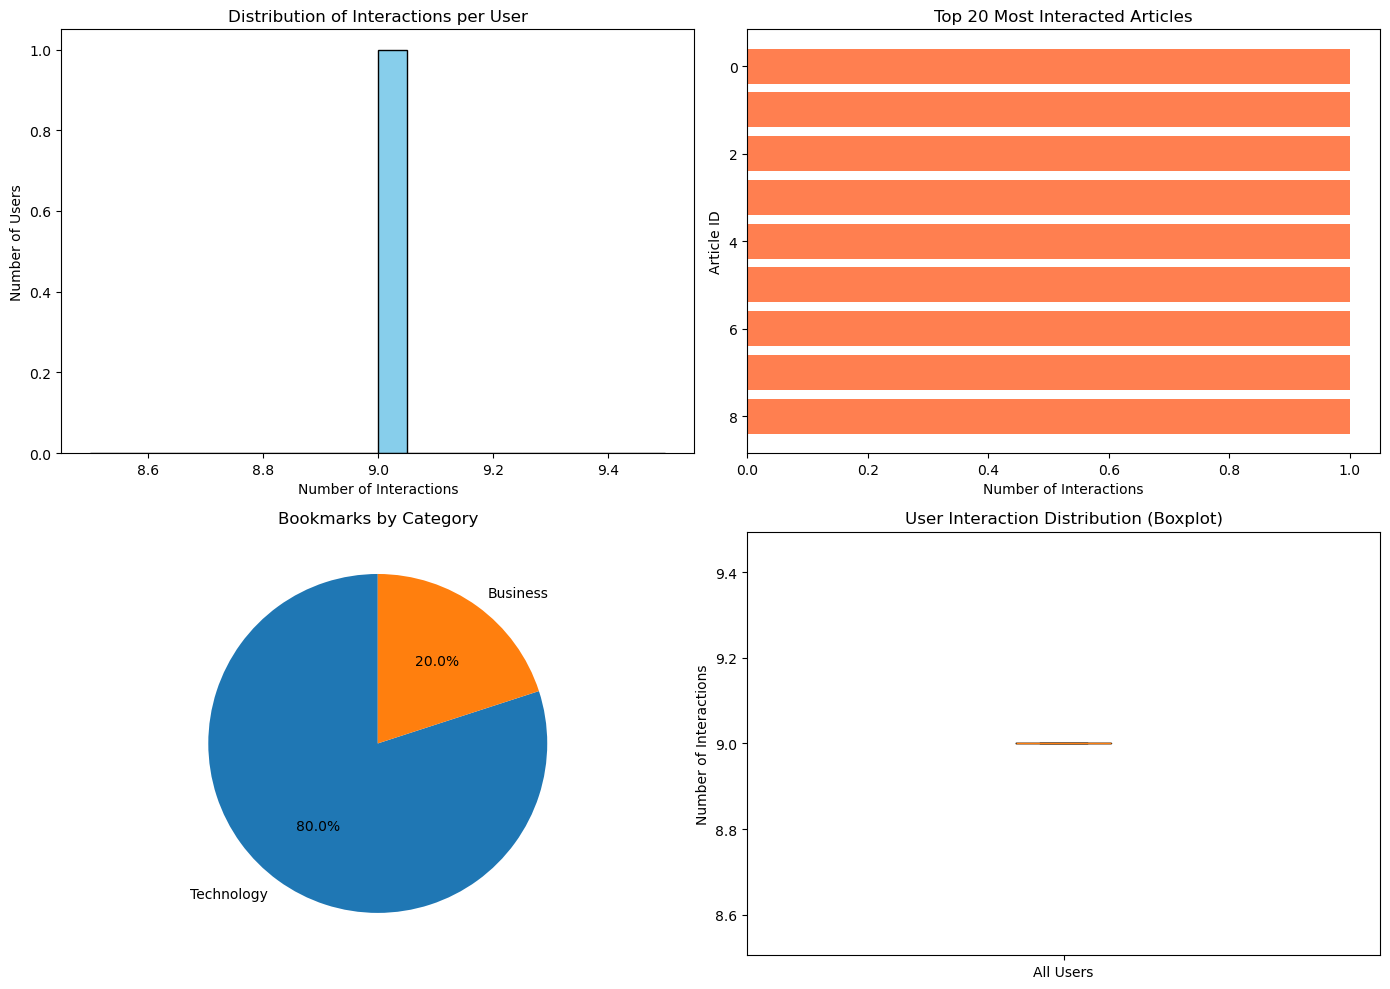

✅ Visualization saved to: d:\UMN\MAP\NewsApp\ml_training\datasets\data_analysis_20251206_182020.png


In [62]:
# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. User interaction distribution
user_interactions = df_interactions['user_id'].value_counts()
axes[0, 0].hist(user_interactions.values, bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Interactions per User')
axes[0, 0].set_xlabel('Number of Interactions')
axes[0, 0].set_ylabel('Number of Users')

# 2. Article popularity
article_popularity = df_interactions['article_id'].value_counts().head(20)
axes[0, 1].barh(range(len(article_popularity)), article_popularity.values, color='coral')
axes[0, 1].set_title('Top 20 Most Interacted Articles')
axes[0, 1].set_xlabel('Number of Interactions')
axes[0, 1].set_ylabel('Article ID')
axes[0, 1].invert_yaxis()

# 3. Bookmark categories distribution
if len(df_bookmarks) > 0:
    category_counts = df_bookmarks['category'].value_counts()
    axes[1, 0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1, 0].set_title('Bookmarks by Category')
else:
    axes[1, 0].text(0.5, 0.5, 'No bookmarks data', ha='center', va='center')
    axes[1, 0].set_title('Bookmarks by Category (No Data)')

# 4. Total interactions per user (boxplot)
axes[1, 1].boxplot([user_interactions.values], vert=True)
axes[1, 1].set_title('User Interaction Distribution (Boxplot)')
axes[1, 1].set_ylabel('Number of Interactions')
axes[1, 1].set_xticklabels(['All Users'])

plt.tight_layout()
plt.savefig(DATASET_DIR / f'data_analysis_{timestamp}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved to: {DATASET_DIR / f'data_analysis_{timestamp}.png'}")

## Step 7: Build User-Article Interaction Matrix

Create a sparse matrix for collaborative filtering.

In [63]:
# Combine interactions and bookmarks for comprehensive signal
# Interaction score: clicks + (bookmarks * 5) + (reading_time / 30)

# Add bookmark data to interactions (bookmarks are strong positive signals)
bookmark_bonus = 5  # Bookmarks worth 5 clicks

# Create interaction scores
interaction_scores = {}

# Process clicks and reading time
for interaction in interactions_data:
    key = (interaction['user_id'], interaction['article_id'])
    clicks = interaction.get('clicks', 0)
    reading_time = interaction.get('reading_time', 0) / 30  # Normalize by 30 seconds
    interaction_scores[key] = clicks + reading_time

# Add bookmark bonus
for bookmark in bookmarks_data:
    key = (bookmark['user_id'], bookmark['article_id'])
    interaction_scores[key] = interaction_scores.get(key, 0) + bookmark_bonus

# Build matrix
user_ids = sorted(set([k[0] for k in interaction_scores.keys()]))
article_ids = sorted(set([k[1] for k in interaction_scores.keys()]))

# Create mappings
user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
article_to_idx = {article_id: idx for idx, article_id in enumerate(article_ids)}
idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
idx_to_article = {idx: article_id for article_id, idx in article_to_idx.items()}

# Build interaction matrix
n_users = len(user_ids)
n_articles = len(article_ids)
interaction_matrix = np.zeros((n_users, n_articles))

for (user_id, article_id), score in interaction_scores.items():
    user_idx = user_to_idx[user_id]
    article_idx = article_to_idx[article_id]
    interaction_matrix[user_idx, article_idx] = score

print(f"✅ Interaction matrix created:")
print(f"   Shape: {interaction_matrix.shape}")
print(f"   Users: {n_users}")
print(f"   Articles: {n_articles}")
print(f"   Sparsity: {(interaction_matrix == 0).sum() / interaction_matrix.size * 100:.2f}%")
print(f"   Non-zero entries: {(interaction_matrix > 0).sum()}")
print(f"   Max score: {interaction_matrix.max():.2f}")
print(f"   Mean score: {interaction_matrix[interaction_matrix > 0].mean():.2f}")

✅ Interaction matrix created:
   Shape: (1, 9)
   Users: 1
   Articles: 9
   Sparsity: 44.44%
   Non-zero entries: 5
   Max score: 5.00
   Mean score: 5.00


## Step 8: Train Collaborative Filtering Model (SVD)

Using Truncated SVD (Singular Value Decomposition) for matrix factorization.

In [64]:
# Determine number of latent factors (components)
# Rule of thumb: min(n_users, n_articles, 50)
n_components = min(n_users, n_articles, 50)

print(f"🧠 Training SVD model with {n_components} components...")

# Train SVD model
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(interaction_matrix)
article_factors = svd.components_.T

# Normalize factors for better dot product similarity
user_factors_normalized = normalize(user_factors, axis=1)
article_factors_normalized = normalize(article_factors, axis=0)

print(f"✅ Model trained successfully!")
print(f"   User factors shape: {user_factors.shape}")
print(f"   Article factors shape: {article_factors.shape}")
print(f"   Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")
print(f"   Reconstruction error: {np.linalg.norm(interaction_matrix - user_factors @ article_factors.T) / np.linalg.norm(interaction_matrix):.4f}")

🧠 Training SVD model with 1 components...
✅ Model trained successfully!
   User factors shape: (1, 1)
   Article factors shape: (9, 1)
   Explained variance ratio: nan
   Reconstruction error: 0.0000


## Step 9: Extract Category Weights from Preferences

Aggregate category preferences across all users.

In [65]:
# Aggregate category scores across all users
category_totals = {}
category_counts = {}

for pref in preferences_data:
    category_scores = pref.get('category_scores', {})
    for category, score in category_scores.items():
        category_totals[category] = category_totals.get(category, 0) + score
        category_counts[category] = category_counts.get(category, 0) + 1

# Calculate average category weights
category_weights = []
for category in sorted(category_totals.keys()):
    avg_score = category_totals[category] / category_counts[category]
    category_weights.append({
        'category': category,
        'weight': round(avg_score, 4)
    })

print(f"✅ Category weights extracted:")
for cw in category_weights:
    print(f"   {cw['category']}: {cw['weight']}")

# If no categories, use defaults
if not category_weights:
    default_categories = ['Technology', 'Business', 'Sports', 'Entertainment', 'Health', 'Science']
    category_weights = [{'category': cat, 'weight': 5.0} for cat in default_categories]
    print(f"⚠️ No category data found, using default categories")

✅ Category weights extracted:
   Business: 6.2
   Entertainment: 5.0
   Health: 6.4
   Sports: 6.8
   Technology: 8.6


## Step 10: Create ML_ModelArtifacts JSON

Export model in the format expected by the Android app.

In [66]:
# Generate model version
model_version = f"v{timestamp}"

# Create model artifacts structure
model_artifacts = {
    "version": model_version,
    "createdAt": datetime.now().isoformat(),
    "algorithmType": "collaborative_filtering_svd",
    "nComponents": n_components,
    "trainingStats": {
        "totalUsers": n_users,
        "totalArticles": n_articles,
        "totalInteractions": len(interaction_scores),
        "matrixSparsity": float((interaction_matrix == 0).sum() / interaction_matrix.size),
        "explainedVariance": float(svd.explained_variance_ratio_.sum())
    },
    "categoryWeights": category_weights,
    "userFactors": [
        {
            "userId": idx_to_user[idx],
            "factors": user_factors[idx].tolist()
        }
        for idx in range(n_users)
    ],
    "articleFactors": [
        {
            "articleId": idx_to_article[idx],
            "factors": article_factors[idx].tolist()
        }
        for idx in range(n_articles)
    ],
    "metadata": {
        "trainingMethod": "TruncatedSVD",
        "normalization": "L2",
        "bookmarkBonus": bookmark_bonus,
        "readingTimeNormalization": 30
    }
}

print(f"✅ Model artifacts created:")
print(f"   Version: {model_version}")
print(f"   Users: {len(model_artifacts['userFactors'])}")
print(f"   Articles: {len(model_artifacts['articleFactors'])}")
print(f"   Categories: {len(model_artifacts['categoryWeights'])}")
print(f"   Total size: ~{len(json.dumps(model_artifacts)) / 1024:.2f} KB")

✅ Model artifacts created:
   Version: v20251206_182020
   Users: 1
   Articles: 9
   Categories: 5
   Total size: ~1.21 KB


## Step 11: Save Model to JSON File

Save the trained model to `models/` folder.

In [67]:
# Save model JSON
model_file = MODEL_DIR / f"recommendation_model_{model_version}.json"
with open(model_file, 'w') as f:
    json.dump(model_artifacts, f, indent=2)

print(f"✅ Model saved to: {model_file}")
print(f"   File size: {model_file.stat().st_size / 1024:.2f} KB")

# Also save as "latest" for easy upload
latest_model_file = MODEL_DIR / "recommendation_model_latest.json"
with open(latest_model_file, 'w') as f:
    json.dump(model_artifacts, f, indent=2)

print(f"✅ Latest model saved to: {latest_model_file}")

✅ Model saved to: d:\UMN\MAP\NewsApp\ml_training\models\recommendation_model_v20251206_182020.json
   File size: 1.87 KB
✅ Latest model saved to: d:\UMN\MAP\NewsApp\ml_training\models\recommendation_model_latest.json


In [68]:
# Upload model to Firestore (FREE - no Firebase Storage needed!)
print("\n📤 Uploading model to Firestore...")

try:
    # Upload to ml_models collection
    model_ref = db.collection('ml_models').document('recommendation_model_v1')
    model_ref.set(model_artifacts)
    
    print(f"✅ Model uploaded to Firestore successfully!")
    print(f"   Collection: ml_models")
    print(f"   Document: recommendation_model_v1")
    print(f"   Version: {model_version}")
    print(f"   Size: {len(json.dumps(model_artifacts)) / 1024:.2f} KB")
    
    # Verify upload
    uploaded_doc = model_ref.get()
    if uploaded_doc.exists:
        uploaded_data = uploaded_doc.to_dict()
        print(f"\n✅ Verification successful:")
        print(f"   Model version: {uploaded_data.get('version')}")
        print(f"   Total users: {uploaded_data.get('trainingStats', {}).get('totalUsers')}")
        print(f"   Total articles: {uploaded_data.get('trainingStats', {}).get('totalArticles')}")
        print(f"   Total interactions: {uploaded_data.get('trainingStats', {}).get('totalInteractions')}")
    
    print(f"\n🎉 Model is now live! Android app can use it immediately.")
    
except Exception as e:
    print(f"❌ Upload failed: {str(e)}")
    print(f"   You can manually upload the JSON file later.")


📤 Uploading model to Firestore...
✅ Model uploaded to Firestore successfully!
   Collection: ml_models
   Document: recommendation_model_v1
   Version: v20251206_182020
   Size: 1.21 KB

✅ Verification successful:
   Model version: v20251206_182020
   Total users: 1
   Total articles: 9
   Total interactions: 9

🎉 Model is now live! Android app can use it immediately.

✅ Verification successful:
   Model version: v20251206_182020
   Total users: 1
   Total articles: 9
   Total interactions: 9

🎉 Model is now live! Android app can use it immediately.


## Step 12: Upload Model to Firestore (FREE!)

**🎉 No Firebase Storage needed! Save directly to Firestore (100% FREE)**

Firestore advantages over Firebase Storage:
- ✅ **FREE**: 1 GB storage + 50K reads/day on Spark Plan
- ✅ **No download needed**: App queries directly from Firestore
- ✅ **Real-time sync**: Instant updates to all users
- ✅ **Simpler code**: No file download handling

We'll upload the model to:
```
Collection: ml_models
Document: recommendation_model_v1
```

## Step 12.5: Fetch Sample Articles from Cache (Optional)

Fetch sample articles from `articles_cache` to display in recommendations test.

In [69]:
def fetch_articles_from_cache(limit=100):
    """Fetch sample articles from articles_cache collection"""
    print(f"📡 Fetching {limit} articles from cache...")
    
    articles = []
    articles_ref = db.collection('articles_cache').limit(limit)
    
    for doc in tqdm(articles_ref.stream(), desc="Fetching articles", total=limit):
        data = doc.to_dict()
        articles.append({
            'id': doc.id,
            'title': data.get('title', 'Unknown Title'),
            'category': data.get('category', 'Unknown'),
            'summary': data.get('summary', ''),
            'source': data.get('source', 'Unknown'),
            'publishedAt': data.get('publishedAt', ''),
            'heroImageUrl': data.get('heroImageUrl', ''),
            'tag': data.get('tag', ''),
            'isFeatured': data.get('isFeatured', False)
        })
    
    print(f"✅ Fetched {len(articles)} articles from cache")
    return articles

# Fetch articles
try:
    cached_articles = fetch_articles_from_cache(limit=100)
    
    # Save to JSON file
    articles_file = DATASET_DIR / "local_newsfetch.json"
    with open(articles_file, 'w', encoding='utf-8') as f:
        json.dump(cached_articles, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Saved {len(cached_articles)} articles to: {articles_file}")
    
    # Create article lookup dictionary for faster access
    article_lookup = {article['id']: article for article in cached_articles}
    print(f"✅ Article lookup dictionary created with {len(article_lookup)} entries")
    
except Exception as e:
    print(f"⚠️ Could not fetch articles from cache: {e}")
    print(f"   Skipping article details in recommendations test")
    article_lookup = {}
    cached_articles = []

📡 Fetching 100 articles from cache...


Fetching articles: 100%|██████████| 100/100 [00:00<00:00, 949.04it/s]

✅ Fetched 100 articles from cache
✅ Saved 100 articles to: d:\UMN\MAP\NewsApp\ml_training\datasets\local_newsfetch.json
✅ Article lookup dictionary created with 100 entries


## Step 13: Test Model Predictions with Real Articles

Quick test to verify model works correctly with actual article details.

In [70]:
# Pick a random user for testing
test_user_idx = np.random.randint(0, n_users)
test_user_id = idx_to_user[test_user_idx]

print(f"🧪 Testing recommendations for user: {test_user_id}")

# Get user's interaction history
user_history = df_interactions[df_interactions['user_id'] == test_user_id]['article_id'].tolist()
print(f"   User has interacted with {len(user_history)} articles")
print(f"   Total articles in model: {n_articles}")

# Calculate predictions for all articles
user_vector = user_factors[test_user_idx]
predictions = article_factors @ user_vector

# Get top 10 recommendations (excluding already interacted)
article_scores = []
for article_idx in range(n_articles):
    article_id = idx_to_article[article_idx]
    if article_id not in user_history:  # Exclude seen articles
        article_scores.append((article_id, predictions[article_idx]))

article_scores.sort(key=lambda x: x[1], reverse=True)
top_10 = article_scores[:10]

# ============================================================
# FALLBACK: If insufficient training data, use cache articles
# ============================================================
if len(top_10) == 0 and article_lookup:
    print(f"\n⚠️  User has seen all articles in training set (limited data)!")
    print(f"   Using fallback: Recommending from article cache (100 newest articles)")
    
    # Convert category_weights list to dict for lookup
    category_weight_map = {cw['category']: cw['weight'] for cw in category_weights}
    
    # Show top preferred categories
    top_cats = sorted(category_weight_map.items(), key=lambda x: x[1], reverse=True)[:3]
    if top_cats:
        print(f"   Category preferences: {', '.join([f'{cat} ({w:.2f})' for cat, w in top_cats])}")
    
    # Score articles from cache based on category preference
    cache_scores = []
    for article in cached_articles:
        article_id = article['id']
        if article_id not in user_history:  # Exclude seen articles
            # Base score = 1.0, boost by category preference
            score = 1.0
            article_category = article.get('category', '')
            if article_category in category_weight_map:
                score += category_weight_map[article_category]
            
            cache_scores.append((article_id, score))
    
    # Sort by score and take top 10
    cache_scores.sort(key=lambda x: x[1], reverse=True)
    top_10 = cache_scores[:10]
    
    print(f"   Found {len(cache_scores)} unseen articles in cache\n")

print(f"\n✅ Top 10 Recommendations:")
print("=" * 80)

for rank, (article_id, score) in enumerate(top_10, 1):
    # Try to get article details from cached articles
    if article_lookup and article_id in article_lookup:
        article = article_lookup[article_id]
        print(f"\n{rank}. 📰 {article['title']}")
        print(f"   🏷️  Category: {article['category']}")
        print(f"   📊 Score: {score:.4f}")
        print(f"   🔗 Source: {article['source']}")
        if article['summary']:
            summary_preview = article['summary'][:100] + "..." if len(article['summary']) > 100 else article['summary']
            print(f"   📝 {summary_preview}")
    else:
        # Fallback if article details not available
        print(f"\n{rank}. Article ID: {article_id}")
        print(f"   📊 Score: {score:.4f}")

print("\n" + "=" * 80)
print(f"🎉 Recommendation engine is working!")

# Show statistics
if article_lookup:
    found_count = sum(1 for article_id, _ in top_10 if article_id in article_lookup)
    print(f"📊 Article details found: {found_count}/{len(top_10)}")
    
    # Show which articles are in cache
    cache_article_ids = set(article_lookup.keys())
    model_article_ids = set(idx_to_article.values())
    overlap = cache_article_ids & model_article_ids
    
    print(f"\n📊 Statistics:")
    print(f"   Articles in cache: {len(cache_article_ids)}")
    print(f"   Articles in model: {len(model_article_ids)}")
    print(f"   Overlap: {len(overlap)}")
    
    if len(overlap) < 10:
        print(f"\n💡 Tip: Training data is limited ({len(df_interactions)} interactions from {n_users} users)")
        print(f"         For better ML recommendations, collect more user interactions (target: 50+ interactions from 5+ users)")
else:
    print(f"⚠️  No article cache available")

🧪 Testing recommendations for user: zhFn58nGQiciWq6v5oqK7qGevfk2
   User has interacted with 9 articles
   Total articles in model: 9

⚠️  User has seen all articles in training set (limited data)!
   Using fallback: Recommending from article cache (100 newest articles)
   Category preferences: Technology (8.60), Sports (6.80), Health (6.40)
   Found 100 unseen articles in cache


✅ Top 10 Recommendations:

1. 📰 The Blood Ravens are not alone in a new Warhammer 40,000: Dawn of War IV story trailer - Warhammer Community
   🏷️  Category: Technology
   📊 Score: 9.6000
   🔗 Source: Warhammer-community.com
   📝 Reinforcements are on the way.

2. 📰 The Blood Ravens are not alone in a new Warhammer 40,000: Dawn of War IV story trailer - Warhammer Community
   🏷️  Category: Technology
   📊 Score: 9.6000
   🔗 Source: Warhammer-community.com
   📝 Reinforcements are on the way.

3. 📰 The Blood Ravens are not alone in a new Warhammer 40,000: Dawn of War IV story trailer - Warhammer Community
   🏷️

---

## 🎉 Training Complete!

### ✅ What You Have Now:

1. **Dataset Backup** (in `datasets/` folder):
   - `interactions_YYYYMMDD_HHMMSS.json`
   - `preferences_YYYYMMDD_HHMMSS.json`
   - `bookmarks_YYYYMMDD_HHMMSS.json`
   - `metadata_YYYYMMDD_HHMMSS.json`
   - `data_analysis_YYYYMMDD_HHMMSS.png`

2. **Trained Model** (in `models/` folder):
   - `recommendation_model_vYYYYMMDD_HHMMSS.json`
   - `recommendation_model_latest.json` ← **Upload this to Firebase Storage**

### 📤 Next Steps:

1. **Upload model to Firebase Storage**:
   - Go to Firebase Console → Storage
   - Create folder: `ml_models/`
   - Upload `recommendation_model_latest.json` as `recommendation_model_v1.json`

2. **Test in Android app**:
   - App will auto-download model on startup
   - Check logcat for: "ML model downloaded successfully"
   - Recommendations will use ML + rule-based hybrid scoring

3. **Re-train periodically**:
   - Run this notebook again (weekly/monthly)
   - Fetch fresh data from Firestore
   - Upload new model to overwrite old one

### 💰 Cost: 100% FREE!
- No Cloud Functions charges
- Only storage costs (~few KB per model)
- Manual process, but fully automated workflow

---

**Happy Training! 🚀**